Install dependencies

In [82]:
!source .venv/bin/activate
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: pip install --upgrade pip


In [83]:
# Download the dataset
import os
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

dataset_path = 'datasets/datamunge/sign-language-mnist'
dataset_files = [x for x in os.listdir(dataset_path) if x != '.DS_Store']
if not dataset_files:
    api.dataset_download_files("datamunge/sign-language-mnist", path=dataset_path, unzip=True)
    print("Dataset has been downloaded into ", dataset_path)
else:
    print("Dataset is already downloaded into ", dataset_path)

Dataset is already downloaded into  datasets/datamunge/sign-language-mnist


In [84]:
# Visualize the dataset
import pandas as pd
import numpy as np

trainset_csv_path = f'{dataset_path}/sign_mnist_train.csv'
testset_csv_path = f'{dataset_path}/sign_mnist_test.csv'

train_csv = pd.read_csv(trainset_csv_path)
test_csv = pd.read_csv(testset_csv_path)

train_data = np.array(train_csv)
test_data = np.array(test_csv)

numeric_labels = list(range(26))
numeric_to_alpha_label_map = {numeric_label: chr(65 + numeric_label) for numeric_label in numeric_labels}

ab_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
num_classes = [ord(c) - 65 for c in ab_classes]

print(f"train shape: {train_csv.shape}")
print(f"test shape: {test_csv.shape}")

train shape: (27455, 785)
test shape: (7172, 785)


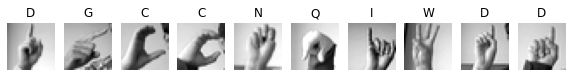

In [85]:
import math
import matplotlib.pyplot as plot


img_size = None

# plot the first 10 images
number_imags_to_plot = 10
img_fig_size = 10
fig, axes = plot.subplots(1, number_imags_to_plot, figsize=(img_fig_size, img_fig_size))
for i, ax in enumerate(axes):
    numeric_label, *img_1d = train_data[i]
    img_1d = np.array(img_1d)
    img_pixel_count = img_1d.shape[0]
    img_size = int(math.sqrt(img_pixel_count))
    ax.imshow(img_1d.reshape((img_size, img_size)), cmap='gray')
    alpha_label = numeric_to_alpha_label_map[numeric_label]
    ax.set_title(alpha_label)
    ax.axis('off')


Text(0.5, 1.0, 'Label')

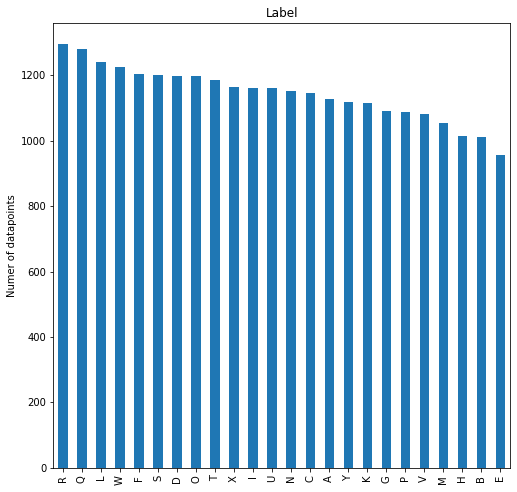

In [86]:
# Show distribution of train data
distribution = train_csv['label'].value_counts(sort=True)
distribution.index = [ numeric_to_alpha_label_map[x] for x in distribution.index]
fig = plot.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
distribution.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numer of datapoints')
ax1.set_title('Label')

In [87]:
# Model implementation
import torch.nn as nn
import torch.nn.functional as F

class SlrModel(nn.Module):
    def __init__(self):
        super(SlrModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels, out_channels=6, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features, out_features=48)
        self.fc3 = nn.Linear(in_features=self.fc2.out_features, out_features=24)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [88]:
# Dataset implementation
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch

class SlrDataset(Dataset):
    def __init__(self, data_csv):
        data_row = np.array(data_csv)
        labels = []
        image_datas = []
        for row in data_row:
            l, *s = row
            labels.append(num_classes.index(l))
            image_datas.append(s)
        self._image_datas = np.array(image_datas, dtype=np.uint8).reshape((-1, img_size, img_size, 1))
        self._labels = np.array(labels, dtype=np.uint8).reshape((-1, 1))
    
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])

        return {
            'image': transform(self._image_datas[idx]).float(),
            'label': torch.from_numpy(self._labels[idx]).float()
        }


In [89]:
# Train the model
import torch.optim as optim
from torch.autograd import Variable

def train(model, optimizer, trainloader, verbose=False):
    criterion = nn.CrossEntropyLoss()
    sum_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = Variable(data['image'].float())
        labels = Variable(data['label'].long())

        # forward propagation
        outputs = model(inputs)

        # backward propagation
        loss = criterion(outputs, labels[:, 0])
        loss.backward()

        # optimize
        optimizer.zero_grad()
        optimizer.step()

        sum_loss += loss.item()
        
        if verbose and i % 100 == 0:
            current_avg_loss = sum_loss / (i + 1)
            print(f'i={i} avg_loss={current_avg_loss}')
   
    avg_loss = sum_loss / len(trainloader)
    return avg_loss     


In [90]:
# Evaluate the model
def evaluate(model, testloader):
    def cal_score_of_1_prediction(actual_prediction, expected_prediction):
        expected = expected_prediction[0][0]
        actual = np.argmax(actual_prediction[0].detach().numpy())
        return 1 if actual == expected else 0
    
    score_sum = 0
    for batch in testloader:
        actual_prediction = model(batch['image'])
        score_sum += cal_score_of_1_prediction(actual_prediction, batch['label'] )
    avg_score = score_sum / len(testloader)
    return avg_score

In [92]:
# main
batch_size = 32
trainset = SlrDataset(train_csv)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = SlrDataset(test_csv)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model = SlrModel().float()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss = train(model, optimizer, trainloader, verbose=True)
print(f'loss={loss}')

accuracy = evaluate(model, testloader)
print(f'accuracy={accuracy}')

i=0 avg_loss=3.1646828651428223
i=100 avg_loss=3.1856420960756813
i=200 avg_loss=3.1846962971473807
i=300 avg_loss=3.1838439287141314
i=400 avg_loss=3.1838929415343706
i=500 avg_loss=3.1835320990480587
i=600 avg_loss=3.1840559357216276
i=700 avg_loss=3.1836619819281955
i=800 avg_loss=3.1835294109158747
loss=3.183453125275654
accuracy=0.06666666666666667
